# 33 MeV D on Ta 

This notebook documents the steps taken to calibrate, aquire, and analyze data from activation foils used to unfold the neutron spectrum from 33 MeV D breakup on Ta.  

This Notebook is broken into the following main sections: <br\>
1) Simulated Results <br\>
2) Simulated Unfold <br\>
3) Calibration <br\>
4) Count Plan <br\>
5) Experimental Setup <br\>

The notebook has dependecies on PScripts, which can be cloned from:
https://github.com/jamesbevins/PyScripts

In [1]:
pwd

u'/Users/zacharysweger/Desktop/BANG/88_Data/Experiments/Activation/33MeVTa_25Apr'

In [2]:
import os
import sys
import peakutils

import pandas as pd
import numpy as np
import copy as cp

from math import sqrt, exp, log
from datetime import datetime
from scipy.optimize import curve_fit
from peakutils.plot import plot as pplot
from matplotlib import pyplot
%matplotlib inline

# Path to PyScripts support functions 
sys.path.insert(0,os.path.abspath(os.path.join("33MeVTa_25Apr" ,"../../../../../PyScripts/src/GeneralNuclear")))
from Counting import parse_spe, simple_peak_counts, germanium_eff_exp, foil_count_time, volume_solid_angle, \
                     optimal_count_plan, germanium_eff_poly, ge_peakfit, get_peak_windows, find_best_fit, \
                     germanium_eff, channel_statistics, count_plan
from BasicNuclearCalcs import decay, production_decay, get_decay_const, fractional_solid_angle
sys.path.insert(0,os.path.abspath(os.path.join("33MeVTa_25Apr" ,"../../../../../PyScripts/src/DataAnalysis")))
from Stats import red_chisq, curve_fit_error4

## Simulated Results

### MCNP

The experimental configuration was simulated in MCNP to get the expected reaction rates.  The Meulder's deuterons on 197Au was used as the source, and the foil pack was suspended center beam 34.62 cm from the wall.

The results are located at <path>\Dropbox\UCB\Research\ETAs\88Inch\Data\Simulated\Activation\16MeVTa\Model

They are sumarized at:

In [3]:
#simFoilPath ="/Users/zacharysweger/Desktop/BANG/88_Data/Simulated/Activation/33MevTa/BeamOnly/33MeVTaFoils.xlsx"
import os.path as path
import sys
Pathto88_Data = path.abspath(path.join("33MeVTa_25Apr" ,"../../../.."))
print Pathto88_Data
simFoilPath = path.abspath(path.join(Pathto88_Data , "Simulated/Activation/33MevTa/BeamOnly/33MeVTaFoils.xlsx"))
print simFoilPath

/Users/zacharysweger/Desktop/BANG/88_Data
/Users/zacharysweger/Desktop/BANG/88_Data/Simulated/Activation/33MevTa/BeamOnly/33MeVTaFoils.xlsx


## Simulated Unfold

Unfold of the MCNP results to test the theroretical ability to unfold given a set of reaction channels.  

### Analysis Pending
This may be accomplished by 1 July 17 by James Bevins

## Calibration

The drawer was a little loose in the stack.  It was pushed to back right for repeatibility.

### Import source data

Calibration was performed using Cs137, Co60, Eu 152, Am241, and Ba133 sources @ 1, 5, 10, 1nd 18 cm.  The data are located in the Calibration folder. The lines used for energy and efficiency calibration are:

#### Energy Calibrations Only
Source   | Line (keV)| BR [%] 
-------- |:---------:|:------:
Y88      |392.87     |97.21   
Y88      |898.042    |93.7   
Y88      |1836.063   |99.2   


#### Energy And Efficiency Calibrations

Source   | Line (keV)| BR [%] 
-------- |:---------:|:------:
Cs137    |661.657    |85.10   
Co60     |1173.23    |99.85  
Co60     |1332.49    |99.98  
Am241    |59.54      |2.14   
Ba133    |80.9979    |32.9    
Ba133    |276.40     |7.16   
Ba133    |302.85     |18.34  
Ba133    |356.01     |62.05  
Eu152    |121.70     |28.53
Eu152    |244.70     |7.55
Eu152    |344.29     |26.59 
Eu152    |778.90     |12.93  
Eu152    |964.06     |14.51
Eu152    |1085.837   |10.11
Eu152    |1112.08    |13.67 
Eu152    |1408.01    |20.87

This data, along with the initial activity and decay information, is also located in the excel file located here:

In [4]:
calibSourcesPath = os.path.abspath('CalibrationSources.xlsx')

Import the source and activity data and format for later analysis:

In [5]:
sources = pd.read_excel(calibSourcesPath, "Sources")
sources.columns = ['source', 'initActivity', 'initActRelUncert', 'initDate', 'halfLife']
sources.index = sources.source
del sources['source']
sources['initDate'] = pd.to_datetime(sources['initDate'])
sources['measDate'] = 0     

print "The calibration source data used: \n\n", sources

The calibration source data used: 

        initActivity  initActRelUncert   initDate      halfLife  measDate
source                                                                   
Am241         10.300           0.01165 1970-01-01  1.364420e+10         0
Eu152          1.062           0.01165 2009-01-01  4.263262e+08         0
Co60           1.007           0.01165 2009-01-01  1.663442e+08         0
Cs137          1.042           0.01165 2009-01-01  9.487232e+08         0
Ba133          1.078           0.01165 2009-01-01  3.327363e+08         0


Import the calibration line and branching ratio data:

In [6]:
lines = pd.read_excel(calibSourcesPath,"Lines")
lines.columns=['isotope','line','branchingRatio']
print "The calibration peak data used: \n\n", lines

The calibration peak data used: 

      isotope       line  branchingRatio
0       Am241    59.5409        0.359000
1   Cs137       661.6570        0.851000
2   Co60       1173.2300        0.998500
3   Co60       1332.4900        0.999826
4   Ba133        80.9979        0.329000
5   Ba133       276.4000        0.071600
6   Ba133       302.8500        0.183400
7   Ba133       356.0100        0.620500
8   Eu152       121.7000        0.285300
9   Eu152       244.7000        0.075500
10  Eu152       344.2900        0.265900
11  Eu152       778.9000        0.129300
12  Eu152       964.0600        0.145100
13  Eu152      1085.8370        0.101100
14  Eu152      1112.0800        0.136700
15  Eu152      1408.0100        0.208700


### Perform software energy calibration

The energy calibration was performed using GammaVision.

[insert calibration procedure here]

### Read in the calibration data

Read in all of the data taken for calibration.  

This procedure assumes: <br/>
1) That there is a folder with only calibration data in the format "isotope_position_anything.Spe".  For example, a valid naming convention is "Co60_1_8Feb17.Spe".  The first field is used to compare against the imported lines, and the second field is to build a location dependent calibration. <br/>
2) Only calibration data lives in the calibration path specified.  <br/>
3) That the calibration order listed above in the table was followed. <br/>

The path the calibration data is:

In [7]:
#calibDataPath = '/Users/zacharysweger/Desktop/BANG/88_Data/Experiments/Activation/33MeVTa_25Apr/Calibration/'
calibDataPath = os.path.abspath('Calibration')

# Variables to allow for multiple positions to be handled at once
posSet = False
posUsed = []

# Storage for parameters that vary by position
liveTime = {}
eCalibParams = {} #ax^2 +bx + c stored as (a,b,c)
data = {}

# Loop over all files
for filename in os.listdir(calibDataPath):
    if filename.endswith(".Spe"): 
        name = os.path.splitext(filename)[0]
        
        # Read data from this file
        print "Processing:", filename
        (time, t, measDate, a, b, c, tmpData) = parse_spe(calibDataPath+'/'+filename)
        
        # Determine position, update data structures if necessary, and store data
        position = int(name.split('_')[1])
        if position not in posUsed:
            posUsed.append(position)
            liveTime[position] = {}
            data[position] = tmpData
            data[position].columns = [name.split('_')[0]]
        else: 
            data[position].loc[:,name.split('_')[0]] = tmpData['counts']
        if name.split('_')[0] in sources.index:
            sources.at[name.split('_')[0], 'measDate'] = measDate
            liveTime[position][name.split('_')[0]] = time
            if name.split('_')[0] == "Eu152":
                eCalibParams[position] = (a, b, c)
for p in posUsed:
    print "\nPosition = {} cm".format(p)
    print "LiveTime:", liveTime[p]
    print "Energy Calibration: {}*ch^2 + {} * ch + {}".format(eCalibParams[p][0],eCalibParams[p][1],eCalibParams[p][2])
    print data[p].head(3)

Processing: Am241_1.Spe
Processing: Am241_10.Spe
Processing: Am241_18.Spe
Processing: Am241_5.Spe
Processing: Ba133_1.Spe
Processing: Ba133_10.Spe
Processing: Ba133_18.Spe
Processing: Ba133_5.Spe
Processing: Co60_1.Spe
Processing: Co60_10.Spe
Processing: Co60_18.Spe
Processing: Co60_5.Spe
Processing: Cs137_1.Spe
Processing: Cs137_10.Spe
Processing: Cs137_18.Spe
Processing: Cs137_5.Spe
Processing: Eu152_1.Spe
Processing: Eu152_10.Spe
Processing: Eu152_18.Spe
Processing: Eu152_5.Spe
Processing: Y88_1.Spe
Processing: Y88_10.Spe
Processing: Y88_18.Spe
Processing: Y88_5.Spe

Position = 1 cm
LiveTime: {'Am241': 101.0, 'Co60': 60.0, 'Ba133': 373.0, 'Cs137': 60.0, 'Eu152': 181.0}
Energy Calibration: 7.56672e-09*ch^2 + 0.3972623 * ch + -0.4220292
   Am241  Ba133  Co60  Cs137  Eu152  Y88
0      0      0     0      0      0    0
1      0      0     0      0      0    0
2      0      0     0      0      0    0

Position = 10 cm
LiveTime: {'Am241': 60.0, 'Co60': 318.0, 'Ba133': 673.0, 'Cs137': 87.0

### Calculate the peak counts

Determine the peak area for each of the lines considered.  Save the data in the lines dataframe. 

This procedure assumes: <br/>
1) That no significant background is present.  No background subtraction is performed. <br/>  


------------------------
Position = 1 cm
------------------------

Am241 
Energy  Peak Area
59.56   2513868   1585




/Users/zacharysweger/Desktop/BANG/PyScripts/src/DataAnalysis/Math.py:104: RuntimeWarning: overflow encountered in exp
  return amplitude*(np.exp(rng*z))/(1+np.exp(z))**4
/Users/zacharysweger/Desktop/BANG/PyScripts/src/DataAnalysis/Math.py:104: RuntimeWarning: overflow encountered in multiply
  return amplitude*(np.exp(rng*z))/(1+np.exp(z))**4


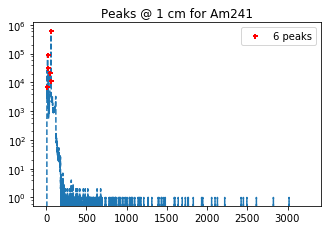


Ba133 
Energy  Peak Area
81.02   407238   638
276.47   35865   189
303.09   98173   313
355.93   290038   538




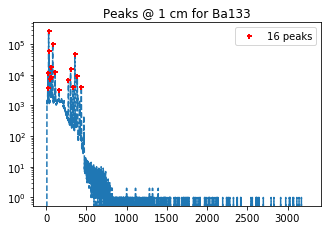


Co60 
Energy  Peak Area
1173.55   18805   137
1333.27   16556   128




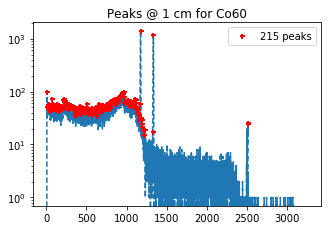


Cs137 
Energy  Peak Area
661.84   70443   265




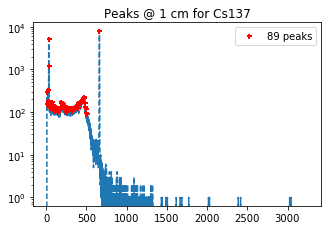


Eu152 
Energy  Peak Area
121.94   163516   404
244.69   23551   153
344.41   83744   289
779.04   18722   136
964.18   14579   120
1086.54   14519   120
1112.37   12359   111
1408.76   15340   123




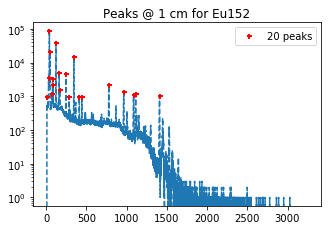


Y88 
Energy  Peak Area




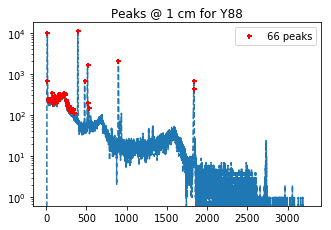

   isotope       line  branchingRatio  measuredCounts  measUncert
0    Am241    59.5409        0.359000         2513868        1585
1    Cs137   661.6570        0.851000           70443         265
2     Co60  1173.2300        0.998500           18805         137
3     Co60  1332.4900        0.999826           16556         128
4    Ba133    80.9979        0.329000          407238         638
5    Ba133   276.4000        0.071600           35865         189
6    Ba133   302.8500        0.183400           98173         313
7    Ba133   356.0100        0.620500          290038         538
8    Eu152   121.7000        0.285300          163516         404
9    Eu152   244.7000        0.075500           23551         153
10   Eu152   344.2900        0.265900           83744         289
11   Eu152   778.9000        0.129300           18722         136
12   Eu152   964.0600        0.145100           14579         120
13   Eu152  1085.8370        0.101100           14519         120
14   Eu152

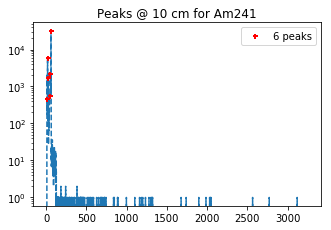


Ba133 
Energy  Peak Area
81.06   87671   296
276.49   19578   139
303.11   23515   153
355.94   68812   262




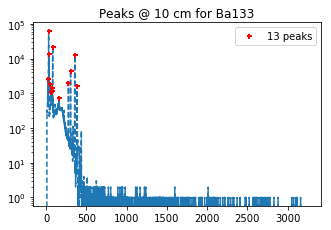


Co60 
Energy  Peak Area
1172.68   11166   105
1333.18   10208   101




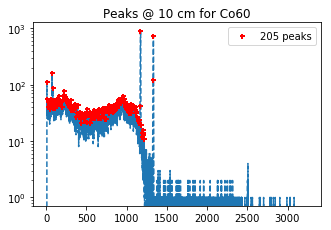


Cs137 
Energy  Peak Area
661.41   10435   102




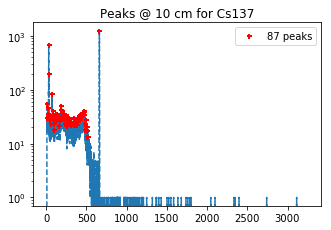


Eu152 
Energy  Peak Area
121.98   177371   421
244.71   32512   180
344.42   83229   288
779.39   20874   144
964.51   19283   138
1086.08   14768   121
1112.30   5747   75
1408.27   20432   142




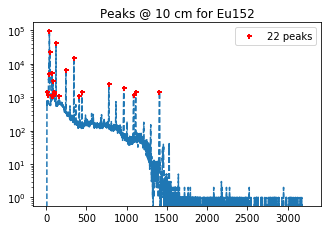


Y88 
Energy  Peak Area




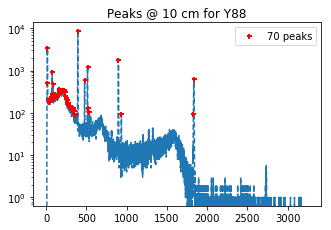

   isotope       line  branchingRatio  measuredCounts  measUncert
0    Am241    59.5409        0.359000          120763         347
1    Cs137   661.6570        0.851000           10435         102
2     Co60  1173.2300        0.998500           11166         105
3     Co60  1332.4900        0.999826           10208         101
4    Ba133    80.9979        0.329000           87671         296
5    Ba133   276.4000        0.071600           19578         139
6    Ba133   302.8500        0.183400           23515         153
7    Ba133   356.0100        0.620500           68812         262
8    Eu152   121.7000        0.285300          177371         421
9    Eu152   244.7000        0.075500           32512         180
10   Eu152   344.2900        0.265900           83229         288
11   Eu152   778.9000        0.129300           20874         144
12   Eu152   964.0600        0.145100           19283         138
13   Eu152  1085.8370        0.101100           14768         121
14   Eu152

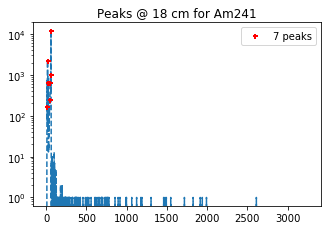


Ba133 
Energy  Peak Area
81.05   90459   300
276.53   10608   102
303.15   24541   156
356.00   72678   269




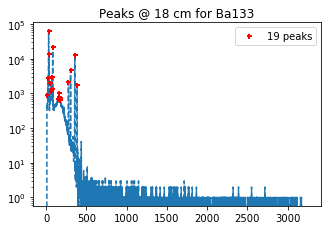


Co60 
Energy  Peak Area
1173.68   11312   106
1333.41   10429   102




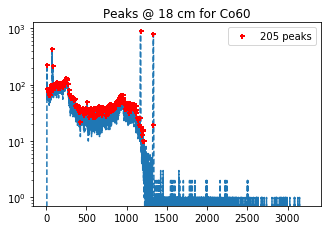


Cs137 
Energy  Peak Area
661.54   13758   117




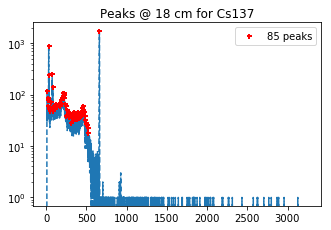


Eu152 
Energy  Peak Area
121.97   84957   291
244.75   16205   127
344.47   41220   203
778.75   10256   101
963.90   9769   98
1085.88   7079   84
1112.50   8151   90
1408.10   10439   102




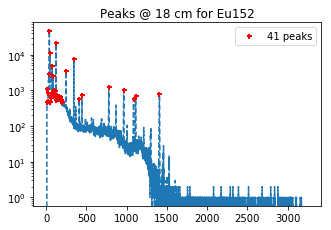


Y88 
Energy  Peak Area




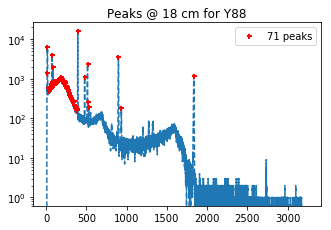

   isotope       line  branchingRatio  measuredCounts  measUncert
0    Am241    59.5409        0.359000           44784         211
1    Cs137   661.6570        0.851000           13758         117
2     Co60  1173.2300        0.998500           11312         106
3     Co60  1332.4900        0.999826           10429         102
4    Ba133    80.9979        0.329000           90459         300
5    Ba133   276.4000        0.071600           10608         102
6    Ba133   302.8500        0.183400           24541         156
7    Ba133   356.0100        0.620500           72678         269
8    Eu152   121.7000        0.285300           84957         291
9    Eu152   244.7000        0.075500           16205         127
10   Eu152   344.2900        0.265900           41220         203
11   Eu152   778.9000        0.129300           10256         101
12   Eu152   964.0600        0.145100            9769          98
13   Eu152  1085.8370        0.101100            7079          84
14   Eu152

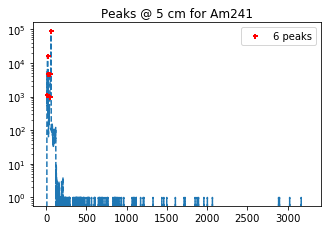


Ba133 
Energy  Peak Area
81.03   111240   333
276.49   11448   106
303.11   27731   166
356.35   82137   286




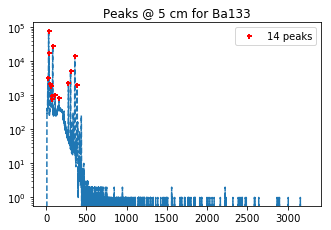


Co60 
Energy  Peak Area
1173.58   8359   91
1333.30   7511   86




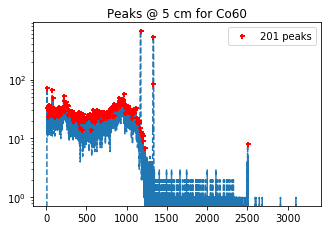


Cs137 
Energy  Peak Area
661.47   21897   147




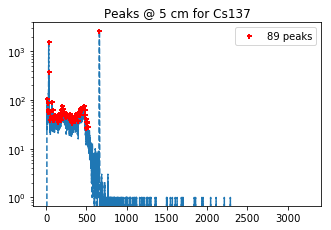


Eu152 
Energy  Peak Area
121.95   104120   322
244.71   17874   133
344.43   48978   221
779.47   11791   108
963.81   10562   102
1086.18   8523   92
1112.40   8979   94
1408.38   11251   106




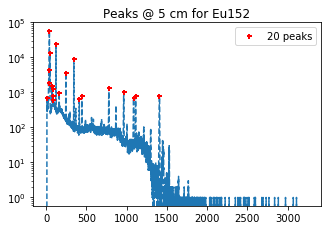


Y88 
Energy  Peak Area




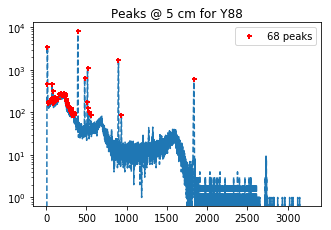

   isotope       line  branchingRatio  measuredCounts  measUncert
0    Am241    59.5409        0.359000          351027         592
1    Cs137   661.6570        0.851000           21897         147
2     Co60  1173.2300        0.998500            8359          91
3     Co60  1332.4900        0.999826            7511          86
4    Ba133    80.9979        0.329000          111240         333
5    Ba133   276.4000        0.071600           11448         106
6    Ba133   302.8500        0.183400           27731         166
7    Ba133   356.0100        0.620500           82137         286
8    Eu152   121.7000        0.285300          104120         322
9    Eu152   244.7000        0.075500           17874         133
10   Eu152   344.2900        0.265900           48978         221
11   Eu152   778.9000        0.129300           11791         108
12   Eu152   964.0600        0.145100           10562         102
13   Eu152  1085.8370        0.101100            8523          92
14   Eu152

In [8]:
# Create a dictionary of data frames to store each of the positional information
peakData = {}
for p in posUsed:
    print "\n------------------------"
    print "Position = {} cm".format(p)
    print "------------------------"
    
    # Update dataframe to store calculated peak information
    lines['measuredCounts'] = 0     
    lines['measUncert'] = 0
    
    for column in data[p]:    
        # Find the peaks and set the windows
        channels = np.asarray(data[p].index)
        counts = np.asarray(data[p][column]).astype(float)
        energy = eCalibParams[p][2]+eCalibParams[p][1]*channels+eCalibParams[p][0]*channels**2
        peaks = peakutils.indexes(counts, thres=0.01, min_dist=10)
        windows = get_peak_windows(peaks)
        
        # Loop over all identified peaks to compare against calibration points loaded previously
        print "\n", data[p][column].name, "\nEnergy  Peak Area"      
        for i in range(len(lines['line'])):
            for e, pk in zip(energy[peaks], peaks):
                # Calculate the total peak counts if a calibration peak
                if abs(e-lines['line'][i]) < 1.5 and data[p][column].name.strip() == lines['isotope'][i].strip():
                    pkChannels = channels[windows[pk][0]:windows[pk][1]]
                    pkCounts = counts[windows[pk][0]:windows[pk][1]]
                    (lines.at[i, 'measuredCounts'], lines.at[i, 'measUncert'], redChiSq) = \
                                 ge_peakfit(pkChannels, pkCounts)
                    
                    print "{:.2f}   {:.0f}   {:.0f}".format(e, lines.at[i, 'measuredCounts'], lines.at[i, 'measUncert'])
            lines.at[i, 'isotope'] = lines.at[i, 'isotope'].strip()
        print "\n"
        
        # Plot the peaks found
        fig = pyplot.figure(figsize=(5,3))
        ax1 = fig.add_axes([0.1, 0.1, 0.8, 0.85])
        ax1.set_yscale('log')
        pplot(energy, counts, peaks)
        pyplot.title('Peaks @ {} cm for {}'.format(p,data[p][column].name))        
        pyplot.show()
        
    print lines
    peakData[p] = cp.deepcopy(lines)

## Propogation of fitting error?

I started to add this in, but never quite made it.  I was planning on using the theano package to take the partial derivatives of the components of the fitting function, but there are other approaches. This may even be captured in RadWare.

import sys
import os
sys.path.insert(0,os.path.abspath('/home/pyne-user/Dropbox/UCB/Computational_Tools/Scripts/Python/DataAnalysis'))
from Math import gaussScalar
#from sympy import symbols, diff
import theano
#x, a, b, c = symbols('x a b c')
#print diff(gaussScalar(x, a, b, c), x)

### Calculate the current activity

Using the data read in from the .spe files, calculate the current activity at the time of the measurement.  

NOTE:  There is a mix in the activity units.  The initActivity is in $\mu$Ci as reported on the source, whereas the curActivity in is Bq.

In [9]:
sources['curActivity'] = 0

for src in sources.index:
    sources.at[src, 'curActivity'] = decay(sources.at[src, 'halfLife'],sources.at[src, 'initActivity'], \
                                        (sources.at[src, 'measDate']-sources.at[src, 'initDate']).total_seconds())
print sources

        initActivity  initActRelUncert   initDate      halfLife  \
source                                                            
Am241         10.300           0.01165 1970-01-01  1.364420e+10   
Eu152          1.062           0.01165 2009-01-01  4.263262e+08   
Co60           1.007           0.01165 2009-01-01  1.663442e+08   
Cs137          1.042           0.01165 2009-01-01  9.487232e+08   
Ba133          1.078           0.01165 2009-01-01  3.327363e+08   

                   measDate  curActivity  
source                                    
Am241   2017-04-19 11:24:51       353270  
Eu152   2017-04-19 11:40:04        25671  
Co60    2017-04-19 11:29:55        12514  
Cs137   2017-04-19 11:27:40        31841  
Ba133   2017-04-19 11:32:47        23117  


### Calculate absolute efficiency

Determine an absolute efficiency curve for each position by curve fitting the experimental data. The germanium_eff_exp function has support for propogation of error, but the germanium_eff, or germanium_eff_poly are also available.  

NOTE: The choice of which functions to onsider can be set with the functions list.

NOTE: The uncertainty only currently captures the uncertainity in the counts and initial activity.  The uncertaities in BR, half lives, and measurement time are sufficiently small that they can be ignored, but there is uncertainty associated with the fit of the peak that is not captured if germanium_eff_exp is not used.  

The fitting function was: germanium_eff
The curve fitting parameters at 1 cm are: [ 0.03826277  0.01839158  0.2155853  -0.02546223]
  with standard deviations at 1 cm of: [ 0.00196076  0.00137811  0.02411926  0.00141893]

   isotope       line  expectedCounts  absEfficiency  effUncert
0    Am241    59.5409    1.280922e+07       0.196255   0.002286
1    Cs137   661.6570    1.625801e+06       0.043328   0.000505
2     Co60  1173.2300    7.497137e+05       0.025083   0.000292
3     Co60  1332.4900    7.507094e+05       0.022054   0.000257
4    Ba133    80.9979    2.836849e+06       0.143553   0.001672
5    Ba133   276.4000    6.173811e+05       0.058092   0.000677
6    Ba133   302.8500    1.581392e+06       0.062080   0.000723
7    Ba133   356.0100    5.350349e+06       0.054209   0.000632
8    Eu152   121.7000    1.325632e+06       0.123349   0.001437
9    Eu152   244.7000    3.508071e+05       0.067134   0.000782
10   Eu152   344.2900    1.235491e+06       0.067782   0.000790
11   Eu152

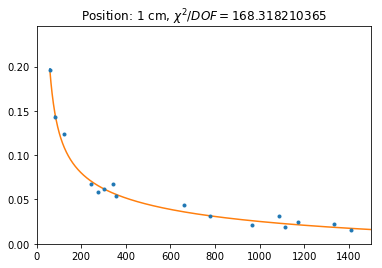

The fitting function was: germanium_eff
The curve fitting parameters at 10 cm are: [ 0.01903892  0.01208938  0.19365513  0.00781639]
  with standard deviations at 10 cm of: [ 0.0002411   0.00016917  0.00296008  0.00015385]

   isotope       line  expectedCounts  absEfficiency  effUncert
0    Am241    59.5409    7.609436e+06       0.015870   0.000185
1    Cs137   661.6570    2.357412e+06       0.004426   0.000052
2     Co60  1173.2300    3.973483e+06       0.002810   0.000033
3     Co60  1332.4900    3.978760e+06       0.002566   0.000030
4    Ba133    80.9979    5.118497e+06       0.017128   0.000200
5    Ba133   276.4000    1.113934e+06       0.017576   0.000205
6    Ba133   302.8500    2.853290e+06       0.008241   0.000096
7    Ba133   356.0100    9.653578e+06       0.007128   0.000083
8    Eu152   121.7000    1.209182e+07       0.014669   0.000171
9    Eu152   244.7000    3.199903e+06       0.010160   0.000118
10   Eu152   344.2900    1.126959e+07       0.007385   0.000086
11   Eu1

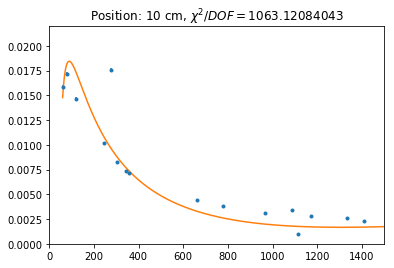

The fitting function was: germanium_eff_exp
The curve fitting parameters at 18 cm are: [  2.94234366e+00   8.13307665e-01   7.47972433e+04  -1.64648262e+00]
  with standard deviations at 18 cm of: [  1.44516846e-01   7.28055380e-03   4.03742302e+04   1.32952662e-01]

   isotope       line  expectedCounts  absEfficiency  effUncert
0    Am241    59.5409    7.736260e+06       0.005789   0.000067
1    Cs137   661.6570    8.101911e+06       0.001698   0.000020
2     Co60  1173.2300    1.058346e+07       0.001069   0.000012
3     Co60  1332.4900    1.059751e+07       0.000984   0.000011
4    Ba133    80.9979    1.388763e+07       0.006514   0.000076
5    Ba133   276.4000    3.022354e+06       0.003510   0.000041
6    Ba133   302.8500    7.741615e+06       0.003170   0.000037
7    Ba133   356.0100    2.619232e+07       0.002775   0.000032
8    Eu152   121.7000    1.543886e+07       0.005503   0.000064
9    Eu152   244.7000    4.085642e+06       0.003966   0.000046
10   Eu152   344.2900    1.4

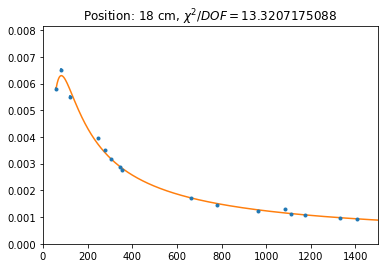

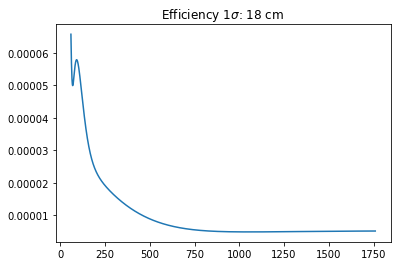

The fitting function was: germanium_eff_exp
The curve fitting parameters at 5 cm are: [  4.23204174e-01   8.23541356e-01   2.19081801e+03  -1.33655422e+00]
  with standard deviations at 5 cm of: [  2.41559342e-02   8.33835332e-03   1.50606986e+03   1.71358672e-01]

   isotope       line  expectedCounts  absEfficiency  effUncert
0    Am241    59.5409    7.609436e+06       0.046130   0.000537
1    Cs137   661.6570    1.869672e+06       0.011712   0.000136
2     Co60  1173.2300    1.162056e+06       0.007193   0.000084
3     Co60  1332.4900    1.163599e+06       0.006455   0.000075
4    Ba133    80.9979    2.403336e+06       0.046286   0.000539
5    Ba133   276.4000    5.230360e+05       0.021888   0.000255
6    Ba133   302.8500    1.339732e+06       0.020699   0.000241
7    Ba133   356.0100    4.532735e+06       0.018121   0.000211
8    Eu152   121.7000    2.702532e+06       0.038527   0.000449
9    Eu152   244.7000    7.151812e+05       0.024992   0.000291
10   Eu152   344.2900    2.518

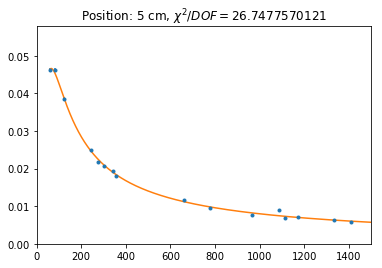

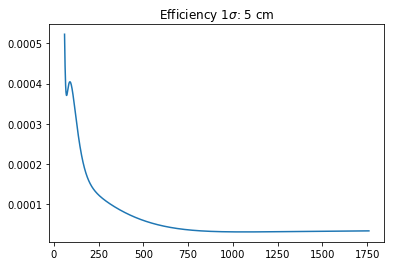

In [10]:
from Counting import germanium_eff
functions=[germanium_eff, germanium_eff_exp]#, germanium_eff_poly]
absEffParams = {}
absEffCov = {}
fitFunc = {} 

for p in posUsed:
    peakData[p]['expectedCounts'] = 0.0
    peakData[p]['absEfficiency'] = 0.0
    peakData[p]['effUncert'] = 0.0
    
    # Calculate the absolute efficiency and uncertainty
    for index, row in peakData[p].iterrows():
        peakData[p].at[index, 'expectedCounts'] = sources.at[peakData[p].at[index, 'isotope'], 'curActivity'] \
                                               * peakData[p].at[index, 'branchingRatio'] \
                                               * liveTime[p][peakData[p].at[index, 'isotope']]
        peakData[p].at[index, 'absEfficiency'] = float(peakData[p].at[index, 'measuredCounts']) \
                                               / float(peakData[p].at[index, 'expectedCounts'])
        peakData[p].at[index, 'effUncert'] = peakData[p].at[index, 'absEfficiency'] * \
                                           sqrt((peakData[p].at[index, 'measUncert'] \
                                           / peakData[p].at[index, 'measuredCounts'])**2 \
                                               + sources.at[peakData[p].at[index, 'isotope'], 'initActRelUncert']**2)
    
    # Fit the data for the current position by finding best fitting routine
    (fitFunc[p], absEffParams[p], absEffCov[p], redChiSq) = find_best_fit(*functions,
                                                     xdata=peakData[p]['line'], ydata=peakData[p]['absEfficiency'],
                                                     sigma=peakData[p]['effUncert'], absolute_sigma=True)
    
    # Output the results
    try:
        print 'The fitting function was: {}'.format(fitFunc[p].__name__)
        print 'The curve fitting parameters at {} cm are: {}'.format(p, absEffParams[p])
        print '  with standard deviations at {} cm of: {}\n'.format(p, np.sqrt(np.diag(absEffCov[p])))
        print peakData[p][['isotope', 'line', 'expectedCounts', 'absEfficiency', 'effUncert']]

        #Plot the Data
        pyplot.axis([0, 1500, 0, 1.25*max(peakData[p]['absEfficiency'])])
        pyplot.errorbar(peakData[p]['line'], peakData[p]['absEfficiency'], peakData[p]['effUncert'], fmt='.')
        pyplot.title('Position: {} cm, $\chi^2/DOF={}$'.format(p, redChiSq))

        #Plot the fit
        xList = np.arange(min(peakData[p]['line']), 1.25*max(peakData[p]['line']), 1)
        yList = map(lambda y: fitFunc[p](y, *absEffParams[p]), xList)
        pyplot.plot(xList, yList)
        pyplot.show()

        #Plot the error
        if fitFunc[p] == germanium_eff_exp:
            pyplot.title('Efficiency 1$\sigma$: {} cm'.format(p))
            xList = np.arange(min(peakData[1]['line']), 1.25*max(peakData[1]['line']), 1)
            yList = map(lambda y: curve_fit_error4(fitFunc[p], np.insert(absEffParams[p], 0, y), y*0.001, 
                                                   absEffCov[p]), xList)
            pyplot.plot(xList, yList)
            pyplot.show()
    except AttributeError:
        print 'No fit was found'
        print peakData[p][['isotope', 'line', 'expectedCounts', 'absEfficiency', 'effUncert']]
        
        #Plot the Data
        pyplot.axis([0, 1500, 0, 1.25*max(peakData[p]['absEfficiency'])])
        pyplot.errorbar(peakData[p]['line'], peakData[p]['absEfficiency'], peakData[p]['effUncert'], fmt='.')
        pyplot.title('Position: {} cm, $\chi^2/DOF={}$'.format(p, redChiSq))
        pyplot.show()

## Count Plan

Develop a count plan based on the planned irradiation. This assumes that you have a priori abs effeciency calibration parameters for the position of interest. 

### Cave01 Normalization Activation Foils

#### Experimental parameters

Specifies experimental parameters for the beam and counting facility used.

runTime = the beam irradiation time in s

transitTime = the minimum time to counting of the first foil in s

background = the background rate at the peak of interest in counts/s

detR = radius of the detector in cm

In [12]:
runTime = 900
transitTime = 600

background = 0.01
detR = 3.245

#### Read in Simulation data

Read from the designated file path.  Manipulate the file to build a dataframe with the information needed for the count plan.  

In [13]:
simVaultFoils = pd.read_excel(simFoilPath, sheetname='BeamBox')

# Delete unneccesary columns for readability and make the index the reactant
simVaultFoils.index = simVaultFoils.Rx
del simVaultFoils['Rx']
del simVaultFoils['Thickness [cm]']
del simVaultFoils['Density']
del simVaultFoils['AW']
del simVaultFoils['Lambda [s^-1]']

# Rename columns for ease of access and add in the statistics column
simVaultFoils.columns = ['foil', 'product', 'gammaEnergy', 'br', 'relStat', 'det2FoilDist', 'normalization', 'rxRate',
                         'rxRateSigma', 'foilR','weightFrac', 'volume', 'halfLife']

# Put branching ratios in fractional form
simVaultFoils['br'] = simVaultFoils['br']/100.

# Calculate the activity following transit time decay for each rx; delete columns no longer needed
simVaultFoils['initActivity'] = 0.0
simVaultFoils['activityUncert'] = 0.0
for ind in simVaultFoils.index:
    simVaultFoils.at[ind,'initActivity'] = production_decay(simVaultFoils.at[ind, 'halfLife'], 0, runTime, \
                                                    simVaultFoils.at[ind, 'rxRate'], \
                                                    simVaultFoils.at[ind, 'normalization'], \
                                                    simVaultFoils.at[ind, 'volume'], transitTime)\
                                                    *get_decay_const(simVaultFoils.at[ind,'halfLife'])\
                                                    *simVaultFoils.at[ind,'br']
    simVaultFoils.at[ind,'activityUncert'] = simVaultFoils.at[ind, 'initActivity']*simVaultFoils.at[ind, 'rxRateSigma']
del simVaultFoils['rxRate']
del simVaultFoils['normalization']
del simVaultFoils['volume']
del simVaultFoils['rxRateSigma']

print simVaultFoils

                foil product  gammaEnergy      br  relStat  det2FoilDist  \
Rx                                                                         
27Al(n,p)b18   Alb18    Mg27      843.760  0.7180     0.01            18   
27Al(n,p)a18   Ala18    Mg27      843.760  0.7180     0.01            18   
27Al(n,a)a18   Ala18    Na24     1368.630  0.9999     0.01            18   
27Al(n,p)b5     Alb5    Mg27      843.760  0.7180     0.01             5   
27Al(n,p)b       Alb    Mg27      843.760  0.7180     0.01             1   
27Al(n,p)a       Ala    Mg27      843.760  0.7180     0.01             1   
27Al(n,a)a       Ala    Na24     1368.630  0.9999     0.01             1   
115In(n,n')18   In18  In115M      336.241  0.4580     0.01            18   
115In(n,g)18    In18  In116M     1293.560  0.8480     0.01            18   
115In(n,n')       In  In115M      336.241  0.4580     0.01             1   
115In(n,g)        In  In116M     1293.560  0.8480     0.01             1   
197Au(n,2n)1

In [14]:
(simVaultFoils, countTime) = count_plan(simVaultFoils, handleTime=75, detR=detR, background=background, 
                                                    units='Bq', toMinute = True, 
                                                    funcDict=fitFunc, funcParamDict=absEffParams )
    
#(simVaultFoils,countOrder,countTime) = optimal_count_plan(simVaultFoils, handleTime=75, detR=detR, background=background, 
#                                                    units='Bq', toMinute = True, 
#                                                    funcDict=fitFunc, funcParamDict=absEffParams )

#print 'The order of counting is: {}\n'.format(countOrder)
print 'Total count time = {:2e} hrs\n'.format(countTime/60)
for ind in simVaultFoils.index:
    print "{:15s} {:4.0f} min".format(ind, simVaultFoils.at[ind,"countTime"])

Total count time = 1.938333e+01 hrs

27Al(n,p)b18       1 min
27Al(n,p)a18       1 min
27Al(n,a)a18       1 min
27Al(n,p)b5        1 min
27Al(n,p)b         1 min
27Al(n,p)a         1 min
27Al(n,a)a         1 min
115In(n,n')18      1 min
115In(n,g)18       1 min
115In(n,n')        1 min
115In(n,g)         1 min
197Au(n,2n)18    547 min
197Au(n,g)18     547 min
197Au(n,2n)       24 min
197Au(n,g)        24 min
58Ni(n,2n)18       3 min
58Ni(n,p)18        3 min
58Ni(n,2n)         1 min
58Ni(n,p)          1 min
90Zr(n,2n)18       1 min
90Zr(n,2n)         1 min


### Cave Activation Foils

#### Experimental Parameters

In [15]:
runTime = 3600*2
transitTime = 360

background = 0.01
detR = 3.245

#### Read in Simulation data

Read from the designated file path.  Manipulate the file to build a dataframe with the information needed for the count plan.  

In [16]:
simCaveFoils = pd.read_excel(simFoilPath, sheetname='Cave')

# Delete unneccesary columns for readability and make the index the reactant
simCaveFoils.index = simCaveFoils.Rx
del simCaveFoils['Rx']
del simCaveFoils['Thickness [cm]']
del simCaveFoils['Density']
del simCaveFoils['AW']
del simCaveFoils['Lambda [s^-1]']

# Rename columns for ease of access and add in the statistics column
simCaveFoils.columns = ['foil', 'product', 'gammaEnergy', 'br', 'relStat', 'det2FoilDist', 'normalization', 'rxRate',
                         'rxRateSigma', 'foilR','weightFrac', 'volume', 'halfLife']

# Put branching ratios in fractional form
simCaveFoils['br'] = simCaveFoils['br']/100.

# Calculate the activity following transit time decay for each rx; delete columns no longer needed
simCaveFoils['initActivity'] = 0.0
simCaveFoils['activityUncert'] = 0.0
for ind in simCaveFoils.index:
    simCaveFoils.at[ind,'initActivity'] = production_decay(simCaveFoils.at[ind, 'halfLife'], 0, runTime, \
                                                    simCaveFoils.at[ind, 'rxRate'], \
                                                    simCaveFoils.at[ind, 'normalization'], \
                                                    simCaveFoils.at[ind, 'volume'], transitTime)\
                                                    *get_decay_const(simCaveFoils.at[ind,'halfLife'])\
                                                    *simCaveFoils.at[ind,'br']
    simCaveFoils.at[ind,'activityUncert'] = simCaveFoils.at[ind, 'initActivity']*simCaveFoils.at[ind, 'rxRateSigma']
del simCaveFoils['rxRate']
del simCaveFoils['normalization']
del simCaveFoils['volume']
del simCaveFoils['rxRateSigma']

print simCaveFoils

            foil product  gammaEnergy      br  relStat  det2FoilDist  foilR  \
Rx                                                                            
27Al(n,p)     Al    Mg27      843.760  0.7180     0.01             1    2.5   
27Al(n,a)     Al    Na24     1368.630  0.9999     0.01             1    2.5   
115In(n,n')   In  In115M      336.241  0.4580     0.01             1    2.5   
115In(n,g)    In  In116M     1293.560  0.8480     0.01             1    2.5   
197Au(n,2n)   Au   Au196      355.700  0.8090     0.01             1    2.5   
58Ni(n,2n)    Ni    Ni57     1377.630  0.8170     0.01             1    2.5   
58Ni(n,p)     Ni    Co58      810.760  0.9945     0.01             1    2.5   
90Zr(n,2n)    Zr    Zr89      909.150  0.9904     0.01             1    2.5   

             weightFrac    halfLife  initActivity  activityUncert  
Rx                                                                 
27Al(n,p)      1.000000      567.48   1573.651463       13.533403  
27Al(

In [17]:
(simCaveFoils, countTime) = count_plan(simCaveFoils, handleTime=75, detR=detR, background=background, 
                                                    units='Bq', toMinute = True, 
                                                    funcDict=fitFunc, funcParamDict=absEffParams )
    
#(simCaveFoils,countOrder,countTime) = optimal_count_plan(simCaveFoils, handleTime=75, detR=detR, background=background, 
#                                                    units='Bq', toMinute = True, 
#                                                    funcDict=fitFunc, funcParamDict=absEffParams )

#print 'The order of counting is: {}\n'.format(countOrder)
print 'Total count time = {:2e} hrs\n'.format(countTime/60.)
for ind in simCaveFoils.index:
    print "{:15s} {:4.0f} min".format(ind, simCaveFoils.at[ind,"countTime"])

Total count time = 2.691667e+01 hrs

27Al(n,p)         42 min
27Al(n,a)         42 min
115In(n,n')       34 min
115In(n,g)        34 min
197Au(n,2n)      114 min
58Ni(n,2n)       626 min
58Ni(n,p)        626 min
90Zr(n,2n)        97 min


#### NOTES:

1) Ni58(n,2n)Ni57 channel will not be clean.  There will be contributions from Ni60(n,4n)Ni57 (threshold 33.15 MeV) and Ni61(n,5n)Ni57 (threshold 41.09 MeV) channels.  Unfortunatetly, nuclear data does not exist for these channels. <br/>
2) Ni58(n,p)Co58 channel will not be clean.  There will be contributions from Ni60(n,2np)Co58 (threshold 20.32 MeV), Ni61(n,3np)Co58 (threshold 28.27 MeV), and Ni62(n,4np)Co58 (threshold 39.03 MeV) channels.  Unfortunatetly, nuclear data does not exist for these channels. <br/>
3) Zr90(n,2n)Zr89 channel will not be clean.  There will be contributions from Zr91(n,3n)Zr89 (threshold 19.38 MeV), Zr92(n,4n)Zr89 (threshold 28.80 MeV), and Zr94(n,6n)Zr89 (threshold 43.21 MeV) channels.  Unfortunatetly, nuclear data does not exist for these channels. <br/>

## Experimental Setup

Counted each foil to verify that there was not residual activity.  

NOTE: Foil drawer has some wiggle room in the stack.  It was pushed all the way back and to the right.  This is not quite centered on the detector, but it is repeatable. The foil itself also doesn't quite fit, so it was ensured that the back edge was in the inset for repeatabiility.  

Zr4 0825 Zr4_1_Background_0831_27Feb17
Al4 0831 Al4_1_Background_0836_27Feb17
In4 0838 Ni4_1_Background_0843_27Feb17
Ni4 0844 Ni4_1_Background_0849_27Feb17

Foil was placed at (65.5 cm, 0 cm, -1 cm)

### Beam On

Start time: 0949:55
Current Integrator: 0
Stop Time:
Current Integrator: 

NOTE: First minute of current monitor calibration data is off. It should read 2 $\mu$A, but it reads a little higher. The recalibration was performed ~1 minute in.  

At ~1003 the beam was stopped because the radiation levels on the roof were too high. At ~1041, the beam was turned on at 1 $\mu$A and adjusted downward until safe levels were reached.  It went down to ~650 nA at 1052.  At 1102, approval was received to go back to 2 $\mu$A.  

5:35 delay 

# Experimental Analysis

In [18]:
eff=germanium_eff_exp(511.0)
std=curve_fit_error4(germanium_eff_exp, np.insert(absEffParams[p], 0, 511), 511*0.001, absEffCov[p])
print "At {} keV, the efficiency is {} +/- {}%".format(511,eff*100,std*100)

At 511 keV, the efficiency is 4.24985141397 +/- 0.00585394848491%


### Data Set 1

#### Import Data Set 1

In [19]:
#DataSet1Path = "/Users/zacharysweger/Desktop/BANG/Bevins_33MeVTa_25Apr/Data/1/"
DataSet1Path = os.path.abspath('CorrectionFactorData')


# Variables to allow for multiple positions to be handled at once
posSet1 = False
posUsed1 = []

# Storage for parameters that vary by position
liveTime1 = {}
data1 = {}

# Loop over all files
for filename in os.listdir(DataSet1Path):
    if filename.endswith(".Spe"): 
        name = os.path.splitext(filename)[0]
        
        # Read data from this file
        print "Processing:", filename
        (time, t, measDate, a, b, c, tmpData) = parse_spe(DataSet1Path+'/'+filename)
        # Determine position, update data structures if necessary, and store data
        position = int(name.split('_')[1])
        if position not in posUsed1:
            posUsed1.append(position)
            liveTime1[position] = {}
            data1[position] = tmpData
            data1[position].columns = [name.split('_')[0]]
        else: 
            data1[position].loc[:,name.split('_')[0]] = tmpData['counts']
            #sources.at[name.split('_')[0], 'measDate'] = measDate
            liveTime1[position][name.split('_')[0]] = time

for p in posUsed1:
    print "\nPosition = {} cm".format(p)
    print "LiveTime:", liveTime1[p]
    print data1[p].head(3)

Processing: Al1a_18_26Apr17.Spe
Processing: Al1a_18_26Apr17_2nd_count.Spe
Processing: Al1a_1_28Apr17.Spe
Processing: Al1a_5_27Apr17.Spe
Processing: Al1b_01_26Apr17.Spe
Processing: Al1b_05_26Apr17.Spe
Processing: Al1b_10_26Apr17.Spe
Processing: Al1b_18_26Apr17.Spe
Processing: Au1_18_26Apr17.Spe
Processing: Au1_1_26Apr17.Spe
Processing: DU1_18_26Apr17_0445.Spe
Processing: DU1_18_26Apr17_0902.Spe
Processing: DU1_18_26Apr17_1038.Spe
Processing: DU1_18_26Apr17_1237.Spe
Processing: DU1_18_26Apr17_1355.Spe
Processing: DU1_18_26Apr17_1635.Spe
Processing: In1_18_26Apr17.Spe
Processing: In1_1_27Apr17.Spe
Processing: In1_5_26Apr17.Spe
Processing: Ni1_18_26Apr17.Spe
Processing: Ni1_1_1May17.Spe
Processing: Ni1_5_26Apr17.Spe
Processing: Ni1_5_27Apr17.Spe
Processing: Zr1_18_26Apr17.Spe
Processing: Zr1_1_3May17.Spe
Processing: Zr1_5_28Apr17.Spe

Position = 18 cm
LiveTime: {'Zr1': 266.0, 'In1': 592.0, 'Au1': 783.0, 'Al1a': 46.0, 'Al1b': 276.0, 'DU1': 9308.0, 'Ni1': 509.0}
   Al1a  Al1b  Au1  DU1  In1 

#### Import Expected Peak Data

In [20]:
linesSet1 = pd.read_excel(simFoilPath, sheetname='DataSet1', usecols=["Foil", "Gamma E [kev]", "BR"])
linesSet1.columns=['isotope','line','branchingRatio']
print "The peak data is: \n\n", linesSet1

The peak data is: 

   isotope      line  branchingRatio
0     Al1b   843.760           71.80
1     Al1b  1368.630           99.99
2     Al1a   843.760           71.80
3     Al1a  1368.630           99.99
4      In1   336.241           45.80
5      In1  1293.560           84.80
6      Au1   355.700           80.90
7      Au1   411.800           95.62
8      Ni1  1377.630           81.70
9      Ni1   810.760           99.45
10     Zr1   909.150           99.04



------------------------
Position = 18 cm
------------------------

Al1a 
Energy  Peak Area
843.51   42908   207
1369.17   39909   199


This is the peak fit with the 15% error from the RadWare fit


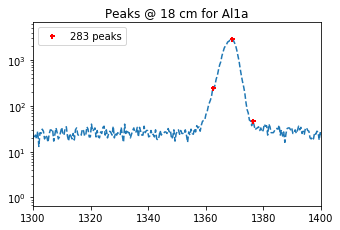

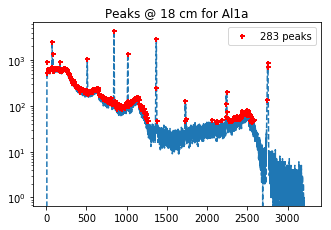


Al1b 
Energy  Peak Area
843.91   36775   191
1369.17   20178   142




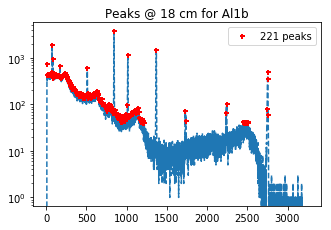


Au1 
Energy  Peak Area
356.00   30581   174
412.02   10350   101




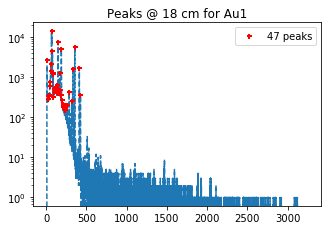


DU1 
Energy  Peak Area




In [ ]:
# Create a dictionary of data frames to store each of the positional information

peakDataSet1 = {}
for p in posUsed1:
    print "\n------------------------"
    print "Position = {} cm".format(p)
    print "------------------------"
    
    # Update dataframe to store calculated peak information
    linesSet1['measuredCounts'] = 0     
    linesSet1['measUncert'] = 0
    
    for column in data1[p]:    
        # Find the peaks and set the windows
        channels = np.asarray(data1[p].index)
        counts = np.asarray(data1[p][column]).astype(float)
        #Use Calibration parameters found in the first part of this notebook
        energy = eCalibParams[p][2]+eCalibParams[p][1]*channels+eCalibParams[p][0]*channels**2
        peaks = peakutils.indexes(counts, thres=0.01, min_dist=10)
        windows = get_peak_windows(peaks)
        
        # Loop over all identified peaks to compare against calibration points loaded previously
        print "\n", data1[p][column].name, "\nEnergy  Peak Area"      
        for i in range(len(linesSet1['line'])):
            for e, pk in zip(energy[peaks], peaks):
                # Calculate the total peak counts if a calibration peak
                if abs(e-linesSet1['line'][i]) < 1.5 and data1[p][column].name.strip() == linesSet1['isotope'][i].strip():
                   # THE FOLLOWING LOOP SKIPS OVER Al1, 843.76keV at 1cm
                    if p != 1 or linesSet1['isotope'][i] != 'Al1a' or linesSet1['line'][i] > 1000:
                        pkChannels = channels[windows[pk][0]:windows[pk][1]]
                        pkCounts = counts[windows[pk][0]:windows[pk][1]]
                        (linesSet1.at[i, 'measuredCounts'], linesSet1.at[i, 'measUncert'], redChiSq) = \
                                     ge_peakfit(pkChannels, pkCounts)
                    
                        print "{:.2f}   {:.0f}   {:.0f}".format(e, linesSet1.at[i, 'measuredCounts'], linesSet1.at[i, 'measUncert'])
            linesSet1.at[i, 'isotope'] = linesSet1.at[i, 'isotope'].strip()
        print "\n"
        
        # Plot the peaks found
        if data1[p][column].name == 'Al1a' and p == 18:
            print 'This is the peak fit with the 15% error from the RadWare fit'
            fig = pyplot.figure(figsize=(5,3))
            ax1 = fig.add_axes([0.1, 0.1, 0.8, 0.85])
            pyplot.xlim([1300,1400])
            ax1.set_yscale('log')
            pplot(energy, counts, peaks)
            pyplot.title('Peaks @ {} cm for {}'.format(p,data1[p][column].name))        
            pyplot.show()
            
        fig = pyplot.figure(figsize=(5,3))
        ax1 = fig.add_axes([0.1, 0.1, 0.8, 0.85])
        ax1.set_yscale('log')
        pplot(energy, counts, peaks)
        pyplot.title('Peaks @ {} cm for {}'.format(p,data1[p][column].name))        
        pyplot.show()
    
        
    print linesSet1
    peakDataSet1[p] = cp.deepcopy(linesSet1)

### Data Set 2

#### Import Data Set 2

In [20]:
#DataSet2Path = "/Users/zacharysweger/Desktop/BANG/Bevins_33MeVTa_25Apr/Data/2/"
DataSet2Path = os.path.abspath('BeamOnlyData')

# Variables to allow for multiple positions to be handled at once
posSet2 = False
posUsed2 = []

# Storage for parameters that vary by position
liveTime2 = {}
data2 = {}

# Loop over all files
for filename in os.listdir(DataSet2Path):
    if filename.endswith(".Spe"): 
        name = os.path.splitext(filename)[0]
        
        # Read data from this file
        print "Processing:", filename
        (time, t, measDate, a, b, c, tmpData) = parse_spe(DataSet2Path+'/'+filename)
        # Determine position, update data structures if necessary, and store data
        position = int(name.split('_')[1])
        if position not in posUsed2:
            posUsed2.append(position)
            liveTime2[position] = {}
            data2[position] = tmpData
            data2[position].columns = [name.split('_')[0]]
        else: 
            data2[position].loc[:,name.split('_')[0]] = tmpData['counts']
            #sources.at[name.split('_')[0], 'measDate'] = measDate
            liveTime2[position][name.split('_')[0]] = time

for p in posUsed2:
    print "\nPosition = {} cm".format(p)
    print "LiveTime:", liveTime2[p]
    print data2[p].head(3)

Processing: Al2_1_26April17.Spe
Processing: Au2_1_26April17.Spe
Processing: In2_1_26April17.Spe
Processing: Ni2_1_27Apr17_1200.Spe
Processing: Zr2_1_26April17.Spe

Position = 1 cm
LiveTime: {'Ni2': 44060.0, 'Au2': 8499.0, 'Zr2': 7624.0, 'In2': 2798.0}
   Al2  Au2  In2  Ni2  Zr2
0    0    0    0    0    0
1    0    0    0    0    0
2    0    0    0    0    0


#### Import Expected Peak Data

In [21]:
linesSet2 = pd.read_excel(simFoilPath, sheetname='DataSet2', usecols=["Foil", "Gamma E [kev]", "BR"])
linesSet2.columns=['isotope','line','branchingRatio']
print "The peak data is: \n\n", linesSet2

The peak data is: 

  isotope      line  branchingRatio
0     Al2   843.760           71.80
1     Al2  1368.630           99.99
2     In2   336.241           45.80
3     In2  1293.560           84.80
4     Au2   355.700           80.90
5     Au2   411.800           95.62
6     Ni2  1377.630           81.70
7     Ni2   810.760           99.45
8     Zr2   909.150           99.04



------------------------
Position = 1 cm
------------------------

Al2 
Energy  Peak Area
843.79   20141   141
1368.24   11267   106




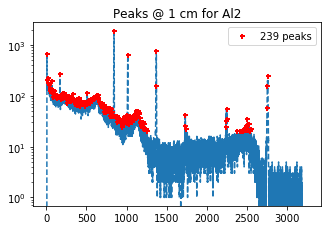


Au2 
Energy  Peak Area
355.93   11093   105
411.94   8711   93




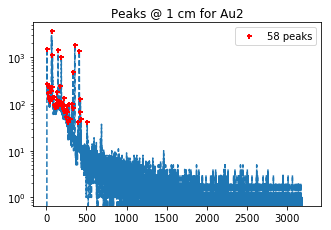


In2 
Energy  Peak Area
336.46   134110   366
1293.54   78222   279




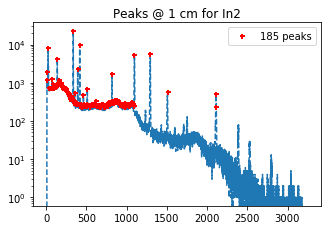


Ni2 
Energy  Peak Area
1377.77   7840   88
811.22   19529   139




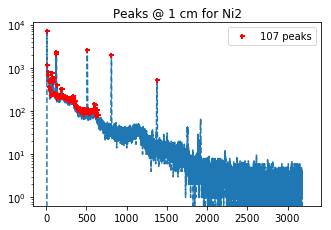


Zr2 
Energy  Peak Area
909.35   10955   104




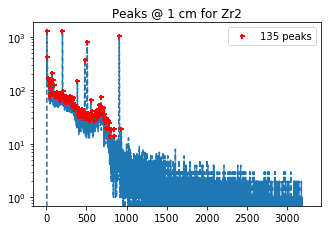

  isotope      line  branchingRatio  measuredCounts  measUncert
0     Al2   843.760           71.80           20141         141
1     Al2  1368.630           99.99           11267         106
2     In2   336.241           45.80          134110         366
3     In2  1293.560           84.80           78222         279
4     Au2   355.700           80.90           11093         105
5     Au2   411.800           95.62            8711          93
6     Ni2  1377.630           81.70            7840          88
7     Ni2   810.760           99.45           19529         139
8     Zr2   909.150           99.04           10955         104


In [22]:
# Create a dictionary of data frames to store each of the positional information

peakDataSet2 = {}
for p in posUsed2:
    print "\n------------------------"
    print "Position = {} cm".format(p)
    print "------------------------"
    
    # Update dataframe to store calculated peak information
    linesSet2['measuredCounts'] = 0     
    linesSet2['measUncert'] = 0
    
    for column in data2[p]:    
        # Find the peaks and set the windows
        channels = np.asarray(data2[p].index)
        counts = np.asarray(data2[p][column]).astype(float)
        #Use Calibration parameters found in the first part of this notebook
        energy = eCalibParams[p][2]+eCalibParams[p][1]*channels+eCalibParams[p][0]*channels**2
        peaks = peakutils.indexes(counts, thres=0.01, min_dist=10)
        windows = get_peak_windows(peaks)
        
        # Loop over all identified peaks to compare against calibration points loaded previously
        print "\n", data2[p][column].name, "\nEnergy  Peak Area"      
        for i in range(len(linesSet2['line'])):
            for e, pk in zip(energy[peaks], peaks):
                # Calculate the total peak counts if a calibration peak
                if abs(e-linesSet2['line'][i]) < 1.5 and data2[p][column].name.strip() == linesSet2['isotope'][i].strip():
                    pkChannels = channels[windows[pk][0]:windows[pk][1]]
                    pkCounts = counts[windows[pk][0]:windows[pk][1]]
                    (linesSet2.at[i, 'measuredCounts'], linesSet2.at[i, 'measUncert'], redChiSq) = \
                                 ge_peakfit(pkChannels, pkCounts)
                    
                    print "{:.2f}   {:.0f}   {:.0f}".format(e, linesSet2.at[i, 'measuredCounts'], linesSet2.at[i, 'measUncert'])
            linesSet2.at[i, 'isotope'] = linesSet2.at[i, 'isotope'].strip()
        print "\n"
        
        # Plot the peaks found
        fig = pyplot.figure(figsize=(5,3))
        ax1 = fig.add_axes([0.1, 0.1, 0.8, 0.85])
        ax1.set_yscale('log')
        pplot(energy, counts, peaks)
        pyplot.title('Peaks @ {} cm for {}'.format(p,data2[p][column].name))        
        pyplot.show()
        
    print linesSet2
    peakDataSet2[p] = cp.deepcopy(linesSet2)

### Data Set 3

In [23]:
#DataSet3Path = "/Users/zacharysweger/Desktop/BANG/Bevins_33MeVTa_25Apr/Data/3/"
DataSet3Path = os.path.abspath('ETAData')

# Variables to allow for multiple positions to be handled at once
posSet3 = False
posUsed3 = []

# Storage for parameters that vary by position
liveTime3 = {}
data3 = {}

# Loop over all files
for filename in os.listdir(DataSet3Path):
    if filename.endswith(".Spe"): 
        name = os.path.splitext(filename)[0]
        
        # Read data from this file
        print "Processing:", filename
        (time, t, measDate, a, b, c, tmpData) = parse_spe(DataSet3Path+'/'+filename)
        # Determine position, update data structures if necessary, and store data
        position = int(name.split('_')[1])
        if position not in posUsed3:
            posUsed3.append(position)
            liveTime3[position] = {}
            data3[position] = tmpData
            data3[position].columns = [name.split('_')[0]]
        else: 
            data3[position].loc[:,name.split('_')[0]] = tmpData['counts']
            #sources.at[name.split('_')[0], 'measDate'] = measDate
            liveTime3[position][name.split('_')[0]] = time

for p in posUsed3:
    print "\nPosition = {} cm".format(p)
    print "LiveTime:", liveTime3[p]
    print data3[p].head(3)

Processing: Al3_1_27Apr17.Spe
Processing: Au3_1_27Apr17.Spe
Processing: In3_1_27Apr17.Spe
Processing: Ni3_1_27Apr17.Spe
Processing: Zr3_1_27Apr17.Spe

Position = 1 cm
LiveTime: {'Ni3': 22542.0, 'Au3': 3089.0, 'Zr3': 2707.0, 'In3': 564.0}
   Al3  Au3  In3  Ni3  Zr3
0    0    0    0    0    0
1    0    0    0    0    0
2    0    0    0    0    0


In [24]:
linesSet3 = pd.read_excel(simFoilPath, sheetname='DataSet3', usecols=["Foil", "Gamma E [kev]", "BR"])
linesSet3.columns=['isotope','line','branchingRatio']
print "The peak data is: \n\n", linesSet3

The peak data is: 

  isotope      line  branchingRatio
0     Al3   843.760           71.80
1     Al3  1368.630           99.99
2     In3   336.241           45.80
3     In3  1293.560           84.80
4     Au3   355.700           80.90
5     Au3   411.800           95.62
6     Ni3  1377.630           81.70
7     Ni3   810.760           99.45
8     Zr3   909.150           99.04



------------------------
Position = 1 cm
------------------------

Al3 
Energy  Peak Area
844.59   4885   69
1369.83   29950   173




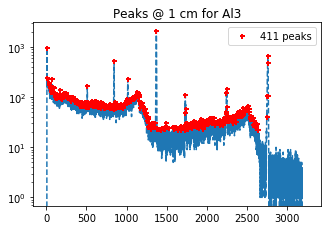


Au3 
Energy  Peak Area
355.93   11057   105
411.94   24320   155




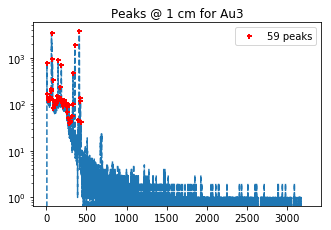


In3 
Energy  Peak Area
336.46   42124   205
1294.73   13065   114




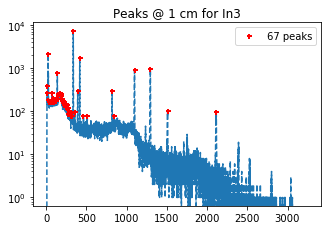


Ni3 
Energy  Peak Area




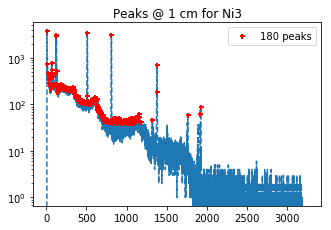


Zr3 
Energy  Peak Area
910.14   10237   101




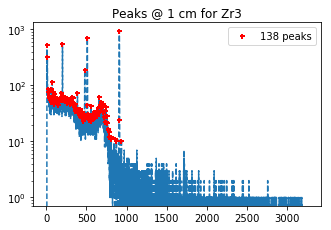

  isotope      line  branchingRatio  measuredCounts  measUncert
0     Al3   843.760           71.80            4885          69
1     Al3  1368.630           99.99           29950         173
2     In3   336.241           45.80           42124         205
3     In3  1293.560           84.80           13065         114
4     Au3   355.700           80.90           11057         105
5     Au3   411.800           95.62           24320         155
6     Ni3  1377.630           81.70               0           0
7     Ni3   810.760           99.45               0           0
8     Zr3   909.150           99.04           10237         101


In [25]:
# Create a dictionary of data frames to store each of the positional information

peakDataSet3 = {}
for p in posUsed3:
    print "\n------------------------"
    print "Position = {} cm".format(p)
    print "------------------------"
    
    # Update dataframe to store calculated peak information
    linesSet3['measuredCounts'] = 0     
    linesSet3['measUncert'] = 0
    
    for column in data3[p]:    
        # Find the peaks and set the windows
        channels = np.asarray(data3[p].index)
        counts = np.asarray(data3[p][column]).astype(float)
        #Use Calibration parameters found in the first part of this notebook
        energy = eCalibParams[p][2]+eCalibParams[p][1]*channels+eCalibParams[p][0]*channels**2
        peaks = peakutils.indexes(counts, thres=0.01, min_dist=10)
        windows = get_peak_windows(peaks)
        
        # Loop over all identified peaks to compare against calibration points loaded previously
        print "\n", data3[p][column].name, "\nEnergy  Peak Area"      
        for i in range(len(linesSet3['line'])):
            for e, pk in zip(energy[peaks], peaks):
                # Calculate the total peak counts if a calibration peak
                if abs(e-linesSet3['line'][i]) < 1.5 and data3[p][column].name.strip() == linesSet3['isotope'][i].strip():
                    # THE FOLLOWING IS A TEMPORARY LOOP TO SKIP OVER NI3 SINCE IT'S BEING DIFFICULT. REMOVE LATER!!!
                    if linesSet3['isotope'][i] != 'Ni3':
                        pkChannels = channels[windows[pk][0]:windows[pk][1]]
                        pkCounts = counts[windows[pk][0]:windows[pk][1]]
                        (linesSet3.at[i, 'measuredCounts'], linesSet3.at[i, 'measUncert'], redChiSq) = \
                                     ge_peakfit(pkChannels, pkCounts)
                    
                        print "{:.2f}   {:.0f}   {:.0f}".format(e, linesSet3.at[i, 'measuredCounts'], linesSet3.at[i, 'measUncert'])
            linesSet3.at[i, 'isotope'] = linesSet3.at[i, 'isotope'].strip()
        print "\n"
        
        # Plot the peaks found
        fig = pyplot.figure(figsize=(5,3))
        ax1 = fig.add_axes([0.1, 0.1, 0.8, 0.85])
        ax1.set_yscale('log')
        pplot(energy, counts, peaks)
        pyplot.title('Peaks @ {} cm for {}'.format(p,data3[p][column].name))        
        pyplot.show()
        
    print linesSet3
    peakDataSet3[p] = cp.deepcopy(linesSet3)